<a href="https://colab.research.google.com/github/Soumya-Guptaa/Machine-Learning-Collection/blob/master/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F


In [14]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # Normalize to range [-1, 1]
])

In [3]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
validation_set_len = 10000
train_dataset_len = len(train_dataset) - validation_set_len
train_dataset , validation_dataset = random_split(train_dataset ,[train_dataset_len , validation_set_len])



100%|██████████| 170498071/170498071 [00:13<00:00, 12985155.70it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

64
torch.Size([3, 32, 32])


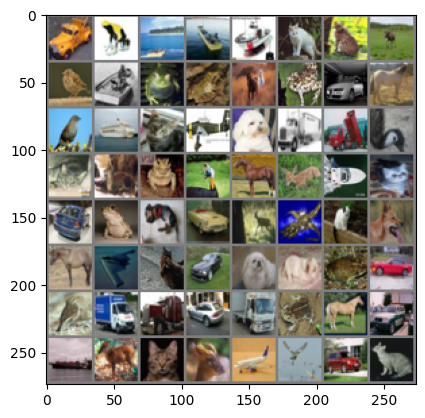

tensor([9, 6, 8, 8, 8, 3, 3, 4, 2, 8, 6, 6, 7, 6, 1, 7, 2, 8, 3, 0, 5, 9, 9, 2,
        3, 4, 6, 2, 7, 4, 8, 3, 1, 6, 5, 1, 4, 2, 3, 5, 7, 0, 3, 1, 5, 5, 6, 1,
        2, 9, 9, 1, 9, 6, 7, 1, 8, 4, 3, 4, 0, 2, 1, 3])


In [43]:
import numpy as np
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of images
for images, labels in train_loader:
    print(len(images))
    # Show images
    print(images[0].shape)
    imshow(torchvision.utils.make_grid(images))
    print(labels)
    break  # Display only the first batch of images


BUILDING THE MODEL

In [50]:
class ImageClassifier(nn.Module):
  def __init__(self, ):
      super(ImageClassifier, self).__init__()
      self.network = nn.Sequential(
          nn.Conv2d(3,32,kernel_size=3 , padding=1) ,
          nn.ReLU(),
          nn.Conv2d(32,64,kernel_size=3 , stride=1 , padding=1) ,
          nn.ReLU(),
          nn.MaxPool2d(2,2),
          nn.Conv2d(64,128,kernel_size=3 , stride=1 , padding=1) ,
          nn.ReLU(),
          nn.Conv2d(128,128,kernel_size=3 , stride=1 , padding=1) ,
          nn.ReLU(),
          nn.MaxPool2d(2,2),
          nn.Conv2d(128,256,kernel_size=3 , stride=1 , padding=1) ,
          nn.ReLU(),
          nn.Conv2d(256,256,kernel_size=3 , stride=1 , padding=1) ,
          nn.ReLU(),
          nn.MaxPool2d(2,2),
          nn.Flatten(),
          nn.Linear(256*4*4 , 1024),
          nn.ReLU(),
          nn.Linear(1024, 512),
          nn.ReLU(),
          nn.Linear(512,10))
  def forward(self,x):
    output = self.network(x)
    return output








In [51]:
inp = torch.randn(16,3,32,32) #randomly checking the shape of output of network
mod = ImageClassifier()
out = (mod.forward(inp))
print(out.shape)


torch.Size([16, 10])


In [61]:
def train_loss(out, pred ):
  loss = F.cross_entropy(pred,out)
  return loss
def validation_loss(pred, labels):
    loss = F.cross_entropy(pred, labels)
    total = len(pred)
    count=0
    for i in range(len(pred)):
        if labels[i] == pred[i].argmax():  # Compare predicted classes with true labels
            count += 1

    return loss, count







training

In [54]:


max_epoch = 50
model = ImageClassifier()
model = model.to(device)  # Move the model to GPU
total = validation_set_len

import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []  # To store the training losses for each epoch
val_losses = []    # To store the validation losses for each epoch

for epoch in range(max_epoch):
    # Training Phase
    model.train()  # Set the model in training mode (important for layers like Dropout)
    epoch_train_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        pred = model.forward(images)
        labels = labels.to(torch.long)
        labels = labels.view(-1)
        loss = train_loss(labels, pred)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()  # Accumulate the loss for the entire epoch


    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)

    # Validation Phase
    model.eval()
    epoch_val_loss = 0.0
    accuracy = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU
            pred = model.forward(images)
            labels = labels.to(torch.long)
            labels = labels.view(-1)
            loss, acc = validation_loss( pred,labels)

            epoch_val_loss += loss   # Accumulate the loss for the entire epoch
            accuracy += acc


    epoch_val_loss /= len(validation_loader)
    val_losses.append(epoch_val_loss)
    accuracy = accuracy/total


    print(f"Epoch [{epoch+1}/{max_epoch}] - Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f} Accuracy: {accuracy}")



Epoch [1/50] - Training Loss: 1.7169, Validation Loss: 1.3132 Accuracy: 32.98726114649681
Epoch [2/50] - Training Loss: 1.1812, Validation Loss: 1.0442 Accuracy: 39.64331210191083
Epoch [3/50] - Training Loss: 0.9169, Validation Loss: 0.8608 Accuracy: 44.140127388535035
Epoch [4/50] - Training Loss: 0.7628, Validation Loss: 0.8328 Accuracy: 44.99363057324841
Epoch [5/50] - Training Loss: 0.6469, Validation Loss: 0.7780 Accuracy: 46.82802547770701
Epoch [6/50] - Training Loss: 0.5608, Validation Loss: 0.7610 Accuracy: 46.89171974522293
Epoch [7/50] - Training Loss: 0.4753, Validation Loss: 0.7682 Accuracy: 47.789808917197455
Epoch [8/50] - Training Loss: 0.4031, Validation Loss: 0.7818 Accuracy: 48.01910828025478
Epoch [9/50] - Training Loss: 0.3434, Validation Loss: 0.8656 Accuracy: 46.92356687898089
Epoch [10/50] - Training Loss: 0.2880, Validation Loss: 0.8846 Accuracy: 47.97452229299363
Epoch [11/50] - Training Loss: 0.2341, Validation Loss: 0.9323 Accuracy: 47.968152866242036
Epoch

Testing

In [64]:
with torch.no_grad():
    epoch_val_loss = 0.0
    accuracy=0
total = len(test_dataset)

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)  # Move data to GPU
    pred = model.forward(images)
    labels = labels.to(torch.long)
    labels = labels.view(-1)
    loss, acc = validation_loss( pred,labels)
    epoch_val_loss += loss
    accuracy+=acc


epoch_val_loss /= len(test_loader)
val_losses.append(epoch_val_loss)
accuracy = accuracy/total
print(f"Test Loss: {epoch_val_loss:.4f} accuracy: {accuracy}")



OutOfMemoryError: ignored